<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_rawit_merah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fd4153403d0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_rawit_merah.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


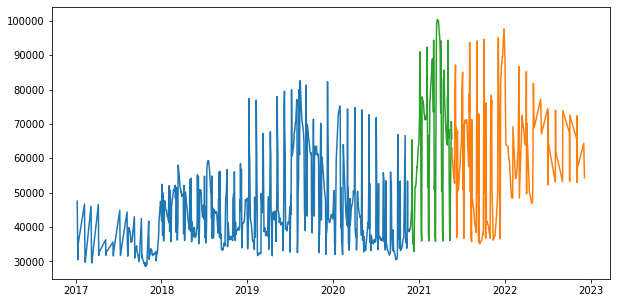

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabairawitmerah_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 65ms/step - loss: 0.1106 - mae: 0.2519 - mape: 90.5090 - val_loss: 0.3349 - val_mae: 0.5289 - val_mape: 92.6693
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0836 - mae: 0.1970 - mape: 60.1379 - val_loss: 0.2774 - val_mae: 0.4750 - val_mape: 80.8293
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0662 - mae: 0.1634 - mape: 50.2244 - val_loss: 0.2347 - val_mae: 0.4368 - val_mape: 80.7271
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0566 - mae: 0.1490 - mape: 53.4793 - val_loss: 0.2036 - val_mae: 0.4067 - val_mape: 81.4534
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0509 - mae: 0.1469 - mape: 60.9119 - val_loss: 0.1838 - val_mae: 0.3859 - val_mape: 81.9485
Epoch 6/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0477 - mae: 0.1478 - mape: 68.1482 - val_loss: 0.1698 - val_mae: 0.3701 - val_mape: 82.31

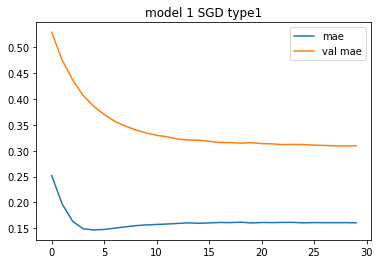

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
15326.044 23.655783 19589.956610467518


,date,actual,prediction
0,2021-05-20,62950,45541.214844
1,2021-05-21,60300,45682.414062
2,2021-05-24,57700,45738.371094
3,2021-05-25,57000,45882.656250
4,2021-05-27,55250,46031.082031
...,...,...,...
229,2022-11-02,53000,48396.871094
230,2022-11-03,72400,48600.285156
231,2022-11-04,57200,48393.929688
232,2022-12-01,64350,48634.757812


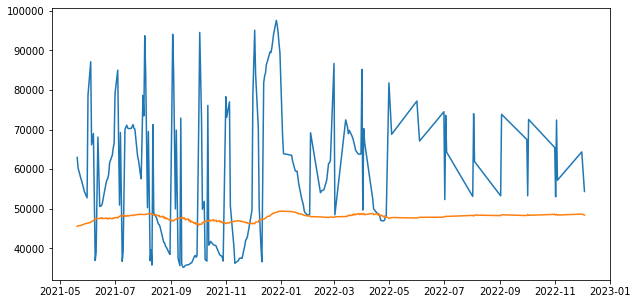

In [ ]:
prediction = forecast_predict(model, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabairawitmerah = pd.DataFrame()
data_new_cabairawitmerah['date'] = y_test
data_new_cabairawitmerah['actual'] = x_test
data_new_cabairawitmerah['prediction'] = data_result
data_new_cabairawitmerah.to_csv('cabairawitmerah_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabairawitmerah.date, data_new_cabairawitmerah.actual)
plt.plot(data_new_cabairawitmerah.date, data_new_cabairawitmerah.prediction)
data_new_cabairawitmerah

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0427 - mae: 0.1664 - mape: 81.2461 - val_loss: 0.0977 - val_mae: 0.2751 - val_mape: 87.9766
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0420 - mae: 0.1653 - mape: 82.1589 - val_loss: 0.0933 - val_mae: 0.2687 - val_mape: 88.9304
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0414 - mae: 0.1648 - mape: 81.5656 - val_loss: 0.0906 - val_mae: 0.2646 - val_mape: 89.5698
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0410 - mae: 0.1634 - mape: 81.5348 - val_loss: 0.0929 - val_mae: 0.2684 - val_mape: 89.2292
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0403 - mae: 0.1619 - mape: 80.4294 - val_loss: 0.0898 - val_mae: 0.2635 - val_mape: 89.9397
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0399 - mae: 0.1615 - mape: 79.8372 - val_loss: 0.0878 - val_mae: 0.2603 - val_mape: 

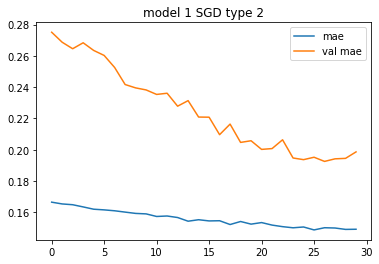

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
13939.284 22.42207 17756.29510905921


,date,actual,prediction
0,2021-05-20,62950,45541.214844
1,2021-05-21,60300,45682.414062
2,2021-05-24,57700,45738.371094
3,2021-05-25,57000,45882.656250
4,2021-05-27,55250,46031.082031
...,...,...,...
229,2022-11-02,53000,48396.871094
230,2022-11-03,72400,48600.285156
231,2022-11-04,57200,48393.929688
232,2022-12-01,64350,48634.757812


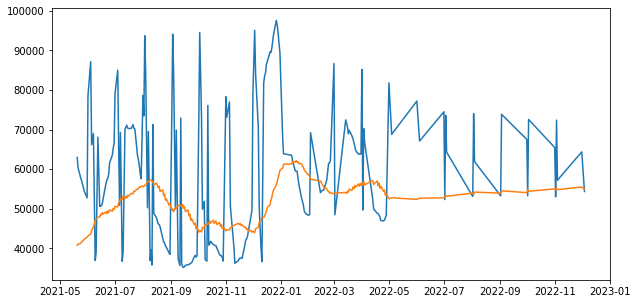

In [ ]:
win_size1 = 60
test_cabairawitmerah_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabairawitmerah_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabairawitmerah_1 = pd.DataFrame()
data_new_cabairawitmerah_1['actual'] = x_test
data_new_cabairawitmerah_1['prediction'] = data_result_1
data_new_cabairawitmerah_1.to_csv('cabairawitmerah_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawitmerah_1.actual)
plt.plot(y_test, data_new_cabairawitmerah_1.prediction)
data_new_cabairawitmerah

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0481 - mae: 0.1651 - mape: 67.4643 - val_loss: 0.0577 - val_mae: 0.1870 - val_mape: 103.8807
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0466 - mae: 0.1700 - mape: 76.2128 - val_loss: 0.0564 - val_mae: 0.1818 - val_mape: 106.9250
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0463 - mae: 0.1720 - mape: 79.4589 - val_loss: 0.0562 - val_mae: 0.1806 - val_mape: 107.7412
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0462 - mae: 0.1735 - mape: 81.6109 - val_loss: 0.0560 - val_mae: 0.1793 - val_mape: 108.5507
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0462 - mae: 0.1733 - mape: 81.5951 - val_loss: 0.0561 - val_mae: 0.1798 - val_mape: 108.2564
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0461 - mae: 0.1727 - mape: 80.9417 - val_loss: 0.0560 - val_mae: 0.1790 - val_mape: 1

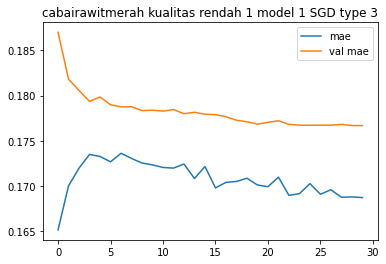

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabairawitmerah kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
13749.806 23.760765 16757.004028166848


,actual,prediction
0,62950,42027.144531
1,60300,42347.718750
2,57700,42625.457031
3,57000,43081.480469
4,55250,43647.890625
...,...,...
229,53000,59725.863281
230,72400,60290.609375
231,57200,59805.519531
232,64350,60563.679688


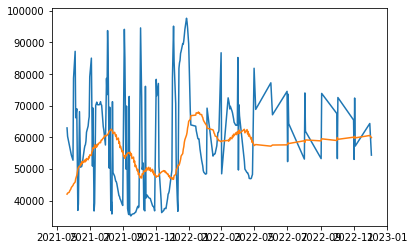

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabairawitmerah_2 = pd.DataFrame()
# data_new_cabairawitmerah1['date'] = date_test
data_new_cabairawitmerah_2['actual'] = x_test
data_new_cabairawitmerah_2['prediction'] = data_result_2
data_new_cabairawitmerah_2.to_csv('cabairawitmerah_model1_sgd_type3')

plt.plot(y_test, data_new_cabairawitmerah_2.actual)
plt.plot(y_test, data_new_cabairawitmerah_2.prediction)
data_new_cabairawitmerah_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.0977 - mae: 0.2277 - mape: 77.1401 - val_loss: 0.2482 - val_mae: 0.4489 - val_mape: 80.6071
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0562 - mae: 0.1525 - mape: 53.1950 - val_loss: 0.1040 - val_mae: 0.2823 - val_mape: 86.6694
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0398 - mae: 0.1523 - mape: 91.2220 - val_loss: 0.0856 - val_mae: 0.2529 - val_mape: 90.2600
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0400 - mae: 0.1531 - mape: 90.9347 - val_loss: 0.0874 - val_mae: 0.2560 - val_mape: 89.8955
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0390 - mae: 0.1517 - mape: 91.2577 - val_loss: 0.0804 - val_mae: 0.2430 - val_mape: 91.4714
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0389 - mae: 0.1502 - mape: 89.0936 - val_loss: 0.0808 - val_mae: 0.2438 - val_mape: 91.390

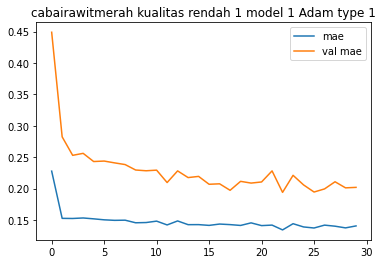

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabairawitmerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
15091.854 24.49253 18908.853376130453


,actual,prediction
0,62950,37879.343750
1,60300,37649.636719
2,57700,38051.546875
3,57000,37970.093750
4,55250,38377.335938
...,...,...
229,53000,56843.281250
230,72400,56884.390625
231,57200,56828.468750
232,64350,56932.367188


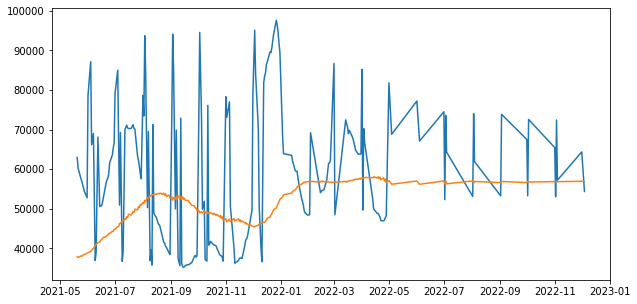

In [ ]:
prediction_a = forecast_predict(model_a, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabairawitmerah_a = pd.DataFrame()
# data_new_cabairawitmerah1['date'] = date_test
data_new_cabairawitmerah_a['actual'] = x_test
data_new_cabairawitmerah_a['prediction'] = data_result_a
data_new_cabairawitmerah_a.to_csv('cabairawitmerah_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabairawitmerah_a.actual)
plt.plot(y_test, data_new_cabairawitmerah_a.prediction)
data_new_cabairawitmerah_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0385 - mae: 0.1553 - mape: 72.8764 - val_loss: 0.0646 - val_mae: 0.2050 - val_mape: 97.0925
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0375 - mae: 0.1494 - mape: 70.4074 - val_loss: 0.0624 - val_mae: 0.2004 - val_mape: 98.4111
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0364 - mae: 0.1487 - mape: 71.0738 - val_loss: 0.0608 - val_mae: 0.1961 - val_mape: 99.5772
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0362 - mae: 0.1483 - mape: 70.2262 - val_loss: 0.0687 - val_mae: 0.2208 - val_mape: 96.0144
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0368 - mae: 0.1499 - mape: 71.0268 - val_loss: 0.0584 - val_mae: 0.1895 - val_mape: 102.4822
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0364 - mae: 0.1473 - mape: 70.3442 - val_loss: 0.0610 - val_mae: 0.1988 - val_mape:

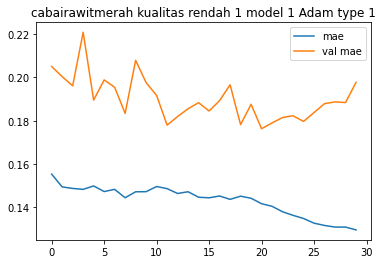

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabairawitmerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
13072.637 20.336506 17124.273298449778


,actual,prediction
0,62950,40590.449219
1,60300,39337.324219
2,57700,44832.152344
3,57000,43238.695312
4,55250,46539.195312
...,...,...
229,53000,54936.734375
230,72400,47532.402344
231,57200,50687.593750
232,64350,53223.964844


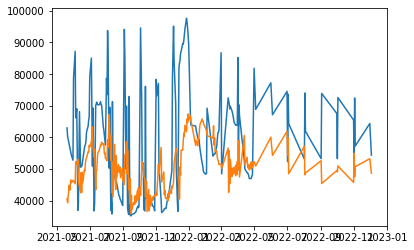

In [ ]:
prediction_a1 = forecast_predict(model_a, test_cabairawitmerah_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabairawitmerah_a1 = pd.DataFrame()
data_new_cabairawitmerah_a1['actual'] = x_test
data_new_cabairawitmerah_a1['prediction'] = data_result_a1
data_new_cabairawitmerah_a1.to_csv('cabairawitmerah_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabairawitmerah_a1.actual)
plt.plot(y_test, data_new_cabairawitmerah_a1.prediction)
data_new_cabairawitmerah_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0389 - mae: 0.1484 - mape: 63.5441 - val_loss: 0.0513 - val_mae: 0.1920 - val_mape: 95.3429
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0373 - mae: 0.1479 - mape: 68.8197 - val_loss: 0.0515 - val_mae: 0.1925 - val_mape: 95.8920
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0371 - mae: 0.1474 - mape: 69.9327 - val_loss: 0.0516 - val_mae: 0.1923 - val_mape: 92.7157
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0371 - mae: 0.1470 - mape: 68.5167 - val_loss: 0.0518 - val_mae: 0.1931 - val_mape: 94.6452
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0370 - mae: 0.1449 - mape: 66.6159 - val_loss: 0.0520 - val_mae: 0.1935 - val_mape: 95.7222
Epoch 6/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0370 - mae: 0.1454 - mape: 67.6307 - val_loss: 0.0519 - val_mae: 0.1931 - val_mape: 94.193

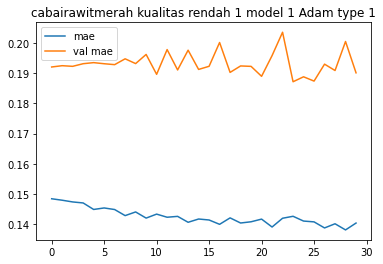

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabairawitmerah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
12279.247 21.262426 15386.034186885196


,actual,prediction
0,62950,41484.855469
1,60300,40818.042969
2,57700,47187.843750
3,57000,46282.855469
4,55250,49520.074219
...,...,...
229,53000,63448.941406
230,72400,56165.082031
231,57200,56722.535156
232,64350,63537.226562


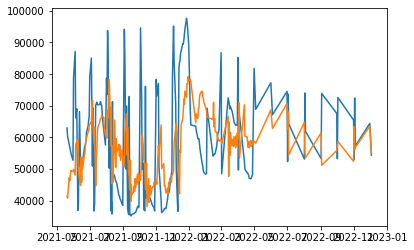

In [ ]:
prediction_a2 = forecast_predict(model_a, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabairawitmerah_a2 = pd.DataFrame()
# data_new_cabairawitmerah1['date'] = date_test
data_new_cabairawitmerah_a2['actual'] = x_test
data_new_cabairawitmerah_a2['prediction'] = data_result_a2
data_new_cabairawitmerah_a2.to_csv('cabairawitmerah_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabairawitmerah_a2.actual)
plt.plot(y_test, data_new_cabairawitmerah_a2.prediction)
data_new_cabairawitmerah_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0892 - mae: 0.2065 - mape: 68.6860 - val_loss: 0.1223 - val_mae: 0.3086 - val_mape: 84.8031
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0397 - mae: 0.1480 - mape: 84.7630 - val_loss: 0.0743 - val_mae: 0.2288 - val_mape: 93.2868
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0381 - mae: 0.1446 - mape: 83.8853 - val_loss: 0.0697 - val_mae: 0.2166 - val_mape: 94.6764
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0380 - mae: 0.1436 - mape: 83.4089 - val_loss: 0.0697 - val_mae: 0.2164 - val_mape: 94.7327
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0380 - mae: 0.1451 - mape: 83.2859 - val_loss: 0.0866 - val_mae: 0.2535 - val_mape: 90.3781
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0382 - mae: 0.1418 - mape: 80.8340 - val_loss: 0.0637 - val_mae: 0.1977 - val_mape: 97.722

17/17 [==============================] - 0s 7ms/step - loss: 0.0612 - mae: 0.1825 - mape: 36.7746


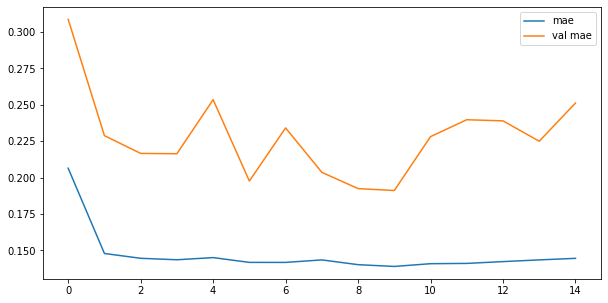

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabairawitmerah1 = pd.DataFrame()
data_new_cabairawitmerah1['actual'] = x_test
data_new_cabairawitmerah1['prediction'] = data_result1
data_new_cabairawitmerah1.to_csv('cabairawitmerah_model2_adam_type1.csv')

data_new_cabairawitmerah1

131/131 [==============================] - 2s 8ms/step
16092.447 24.490675 20970.418021584595


,actual,prediction
0,62950,36049.281250
1,60300,36175.828125
2,57700,36145.046875
3,57000,36327.804688
4,55250,36350.777344
...,...,...
229,53000,50794.589844
230,72400,50834.496094
231,57200,50809.265625
232,64350,50836.812500


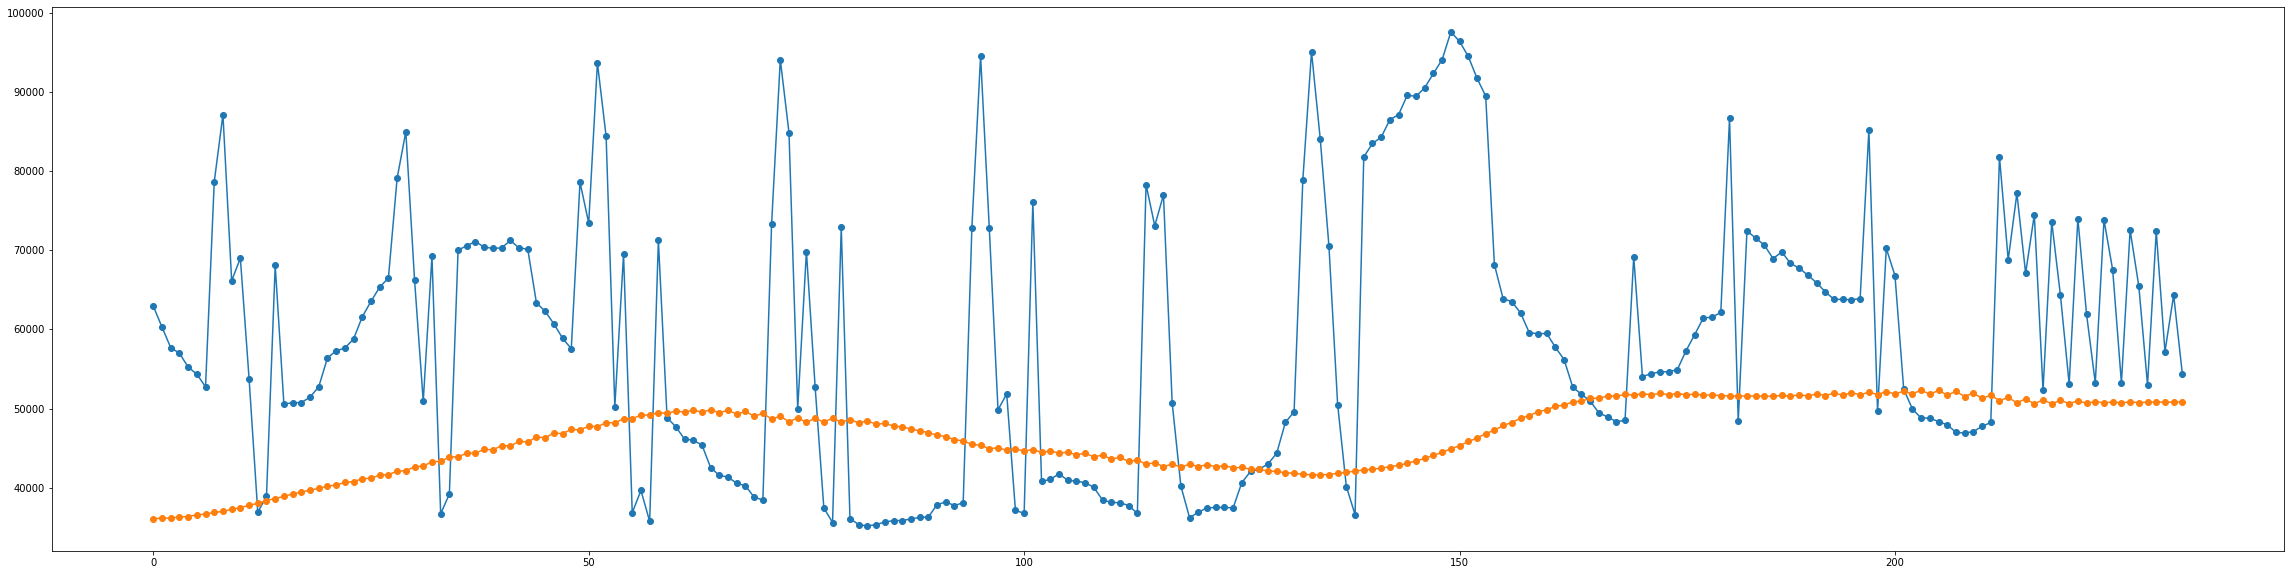

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabairawitmerah1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabairawitmerah1['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 57s 65ms/step - loss: 0.0410 - mae: 0.1584 - mape: 72.1984 - val_loss: 0.0786 - val_mae: 0.2420 - val_mape: 92.7674
Epoch 2/15
718/718 [==============================] - 34s 47ms/step - loss: 0.0379 - mae: 0.1528 - mape: 72.1876 - val_loss: 0.0615 - val_mae: 0.1968 - val_mape: 99.2268
Epoch 3/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0366 - mae: 0.1475 - mape: 69.4054 - val_loss: 0.0713 - val_mae: 0.2266 - val_mape: 95.1023
Epoch 4/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0367 - mae: 0.1499 - mape: 70.9579 - val_loss: 0.0724 - val_mae: 0.2294 - val_mape: 95.0409
Epoch 5/15
718/718 [==============================] - 33s 45ms/step - loss: 0.0366 - mae: 0.1481 - mape: 69.4591 - val_loss: 0.0633 - val_mae: 0.2048 - val_mape: 98.0848
Epoch 6/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0365 - mae: 0.1477 - mape: 71.0919 - val_loss: 0.0654 - val_mae: 0.2114 

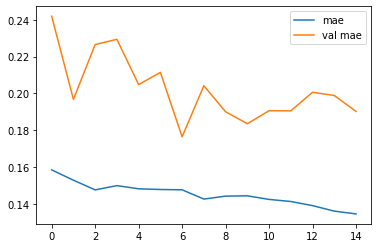

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 3s 9ms/step
14200.61 23.411768 17765.475732442406


,actual,prediction
0,62950,41677.816406
1,60300,41850.660156
2,57700,42070.117188
3,57000,43861.687500
4,55250,43176.394531
...,...,...
229,53000,52143.722656
230,72400,53513.160156
231,57200,53489.035156
232,64350,56266.933594


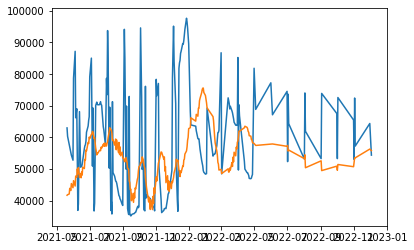

In [14]:
prediction1_1 = forecast_predict(model1, test_cabairawitmerah_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabairawitmerah1_1 = pd.DataFrame()
data_new_cabairawitmerah1_1['actual'] = x_test
data_new_cabairawitmerah1_1['prediction'] = data_result1_1
data_new_cabairawitmerah1_1.to_csv('cabairawitmerah_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabairawitmerah1_1.actual)
plt.plot(y_test, data_new_cabairawitmerah1_1.prediction)
data_new_cabairawitmerah1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
     24/Unknown - 5s 217ms/step - loss: 0.0514 - mae: 0.1724 - mape: 64.1027

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_2 = forecast_predict(model1, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabairawitmerah1_2 = pd.DataFrame()
data_new_cabairawitmerah1_2['actual'] = x_test
data_new_cabairawitmerah1_2['prediction'] = data_result1_2
data_new_cabairawitmerah1_2.to_csv('cabairawitmerah_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawitmerah1_2.actual)
plt.plot(y_test, data_new_cabairawitmerah1_2.prediction)

data_new_cabairawitmerah1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 49ms/step - loss: 0.1064 - mae: 0.2471 - mape: 88.8492 - val_loss: 0.3214 - val_mae: 0.5159 - val_mape: 88.2714
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0892 - mae: 0.2119 - mape: 68.3556 - val_loss: 0.2850 - val_mae: 0.4822 - val_mape: 81.7320
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0758 - mae: 0.1819 - mape: 54.3734 - val_loss: 0.2551 - val_mae: 0.4551 - val_mape: 80.2980
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0661 - mae: 0.1635 - mape: 50.2950 - val_loss: 0.2317 - val_mae: 0.4339 - val_mape: 80.7969
Epoch 5/15
44/44 [==============================] - 1s 29ms/step - loss: 0.0596 - mae: 0.1515 - mape: 51.1701 - val_loss: 0.2124 - val_mae: 0.4154 - val_mape: 81.2214
Epoch 6/15
44/44 [==============================] - 1s 25ms/step - loss: 0.0546 - mae: 0.1479 - mape: 55.7100 - val_loss: 0.1977 - val_mae: 0.4006 - val_mape: 81.574

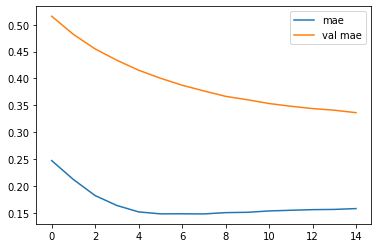

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
16404.514 24.968569 20825.349937035873


,actual,prediction
0,62950,45008.433594
1,60300,44923.226562
2,57700,45026.355469
3,57000,44990.210938
4,55250,45088.980469
...,...,...
229,53000,46077.968750
230,72400,46130.375000
231,57200,46072.531250
232,64350,46125.792969


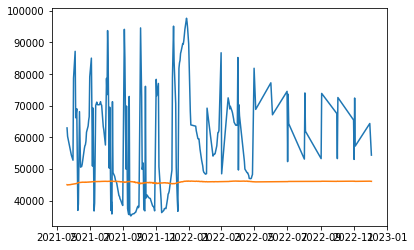

In [ ]:
prediction1_a = forecast_predict(model1_a, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabairawitmerah1_a = pd.DataFrame()
data_new_cabairawitmerah1_a['actual'] = x_test
data_new_cabairawitmerah1_a['prediction'] = data_result1_a
data_new_cabairawitmerah1_a.to_csv('cabairawitmerah_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabairawitmerah1_a.actual)
plt.plot(y_test, data_new_cabairawitmerah1_a.prediction)

data_new_cabairawitmerah1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0454 - mae: 0.1683 - mape: 79.7559 - val_loss: 0.1060 - val_mae: 0.2860 - val_mape: 86.0345
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0438 - mae: 0.1681 - mape: 83.9197 - val_loss: 0.1075 - val_mae: 0.2883 - val_mape: 85.9630
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0438 - mae: 0.1675 - mape: 83.8136 - val_loss: 0.1046 - val_mae: 0.2843 - val_mape: 86.4432
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0434 - mae: 0.1675 - mape: 83.5621 - val_loss: 0.1046 - val_mae: 0.2844 - val_mape: 86.4822
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0433 - mae: 0.1678 - mape: 84.2029 - val_loss: 0.1048 - val_mae: 0.2847 - val_mape: 86.5050
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0431 - mae: 0.1670 - mape: 83.2839 - val_loss: 0.1040 - val_mae: 0.2836 - val_mape: 

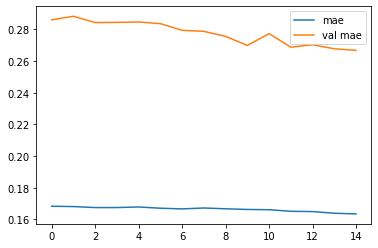

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
14600.454 23.154541 18530.936727537548


,actual,prediction
0,62950,46637.429688
1,60300,46508.539062
2,57700,46669.207031
3,57000,46618.355469
4,55250,46776.136719
...,...,...
229,53000,50938.531250
230,72400,50655.214844
231,57200,50960.464844
232,64350,50734.562500


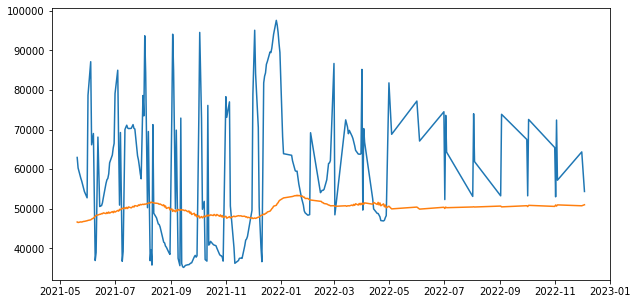

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_cabairawitmerah_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabairawitmerah1_a1 = pd.DataFrame()
data_new_cabairawitmerah1_a1['actual'] = x_test
data_new_cabairawitmerah1_a1['prediction'] = data_result1_a1
data_new_cabairawitmerah1_a1.to_csv('cabairawitmerah_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawitmerah1_a1.actual)
plt.plot(y_test, data_new_cabairawitmerah1_a1.prediction)
data_new_cabairawitmerah1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0575 - mae: 0.1905 - mape: 82.8684 - val_loss: 0.0832 - val_mae: 0.2505 - val_mape: 90.8047
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0558 - mae: 0.1942 - mape: 90.6005 - val_loss: 0.0785 - val_mae: 0.2413 - val_mape: 91.7452
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.1951 - mape: 92.5173 - val_loss: 0.0762 - val_mae: 0.2365 - val_mape: 92.1881
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0550 - mae: 0.1966 - mape: 95.3005 - val_loss: 0.0742 - val_mae: 0.2322 - val_mape: 92.6208
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0549 - mae: 0.1988 - mape: 98.6187 - val_loss: 0.0730 - val_mae: 0.2294 - val_mape: 92.9373
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0547 - mae: 0.1975 - mape: 96.8992 - val_loss: 0.0730 - val_mae: 0.2293 - val_mape: 92.966

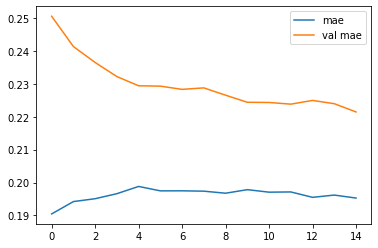

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
13793.299 23.414036 16986.88152663696


,actual,prediction
0,62950,49262.273438
1,60300,49056.519531
2,57700,49333.214844
3,57000,49223.656250
4,55250,49548.925781
...,...,...
229,53000,55411.335938
230,72400,55098.210938
231,57200,55452.753906
232,64350,55192.320312


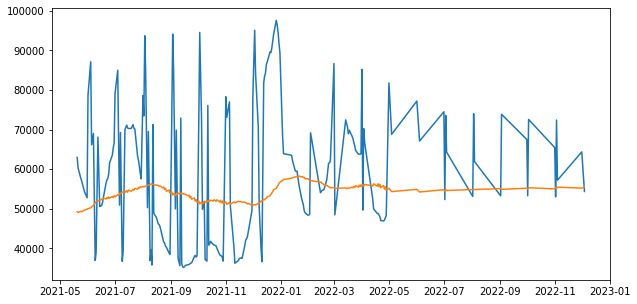

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabairawitmerah1_a2 = pd.DataFrame()
data_new_cabairawitmerah1_a2['actual'] = x_test
data_new_cabairawitmerah1_a2['prediction'] = data_result1_a2
data_new_cabairawitmerah1_a2.to_csv('cabairawitmerah_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawitmerah1_a2.actual)
plt.plot(y_test, data_new_cabairawitmerah1_a2.prediction)

data_new_cabairawitmerah1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.1035 - mae: 0.2428 - mape: 87.1285 - val_loss: 0.3182 - val_mae: 0.5127 - val_mape: 87.2073
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0864 - mae: 0.2057 - mape: 65.0123 - val_loss: 0.2806 - val_mae: 0.4778 - val_mape: 81.1832
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0738 - mae: 0.1771 - mape: 52.3070 - val_loss: 0.2509 - val_mae: 0.4512 - val_mape: 80.3393
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0647 - mae: 0.1606 - mape: 50.0682 - val_loss: 0.2289 - val_mae: 0.4311 - val_mape: 80.8067
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0585 - mae: 0.1511 - mape: 52.0001 - val_loss: 0.2105 - val_mae: 0.4133 - val_mape: 81.2156
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0541 - mae: 0.1471 - mape: 55.8649 - val_loss: 0.1963 - val_mae: 0.3989 - val_mape: 81.546

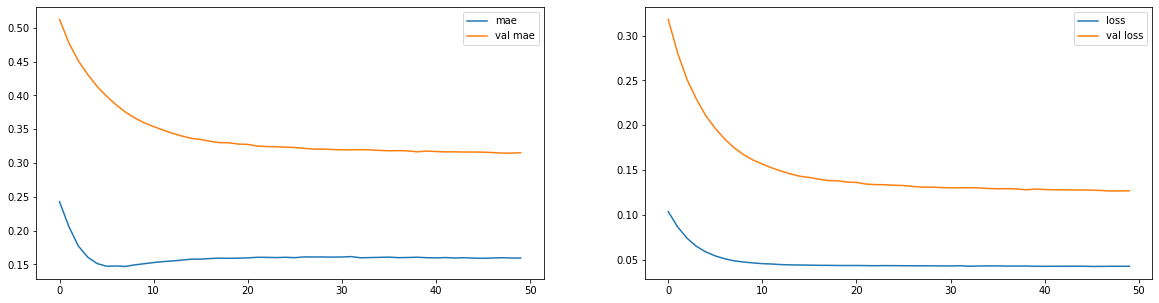

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
15862.931 24.425985 20169.130472085304


,actual,prediction
0,62950,45032.589844
1,60300,45011.175781
2,57700,44902.378906
3,57000,44907.601562
4,55250,45102.113281
...,...,...
229,53000,47821.445312
230,72400,47765.601562
231,57200,47789.796875
232,64350,47812.355469


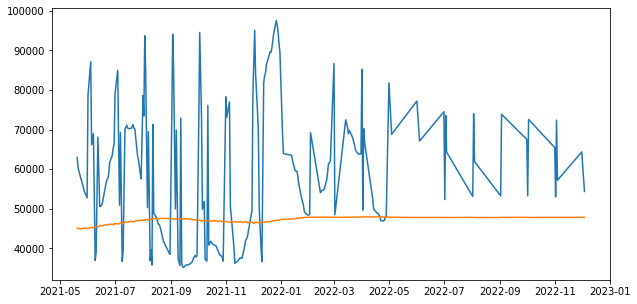

In [ ]:
prediction2 = forecast_predict(model2, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabairawitmerah2 = pd.DataFrame()
data_new_cabairawitmerah2['actual'] = x_test
data_new_cabairawitmerah2['prediction'] = data_result2
data_new_cabairawitmerah2.to_csv('cabairawitmerah_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawitmerah2.actual)
plt.plot(y_test, data_new_cabairawitmerah2.prediction)
data_new_cabairawitmerah2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0448 - mae: 0.1682 - mape: 80.0301 - val_loss: 0.1017 - val_mae: 0.2790 - val_mape: 86.6897
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0433 - mae: 0.1681 - mape: 84.4676 - val_loss: 0.1039 - val_mae: 0.2821 - val_mape: 86.3494
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0436 - mae: 0.1679 - mape: 83.0728 - val_loss: 0.0999 - val_mae: 0.2763 - val_mape: 87.0358
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0432 - mae: 0.1684 - mape: 84.4168 - val_loss: 0.1031 - val_mae: 0.2810 - val_mape: 86.4900
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0432 - mae: 0.1686 - mape: 83.6688 - val_loss: 0.1014 - val_mae: 0.2785 - val_mape: 86.7991
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0431 - mae: 0.1672 - mape: 82.2401 - val_loss: 0.0963 - val_mae: 0.2708 - val_mape: 

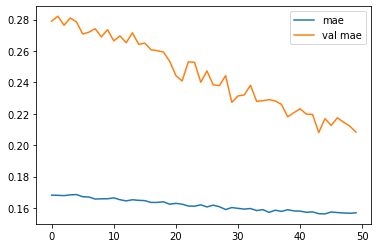

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_cabairawitmerah_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabairawitmerah2_1 = pd.DataFrame()
data_new_cabairawitmerah2_1['actual'] = x_test
data_new_cabairawitmerah2_1['prediction'] = data_result2_1
data_new_cabairawitmerah2_1.to_csv('cabairawitmerah_model3_sgd_type2.csv')

data_new_cabairawitmerah2

199/199 [==============================] - 1s 3ms/step
14671.128 23.648962 18494.235209924198


,actual,prediction
0,62950,45032.589844
1,60300,45011.175781
2,57700,44902.378906
3,57000,44907.601562
4,55250,45102.113281
...,...,...
229,53000,47821.445312
230,72400,47765.601562
231,57200,47789.796875
232,64350,47812.355469


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0509 - mae: 0.1774 - mape: 78.3834 - val_loss: 0.0635 - val_mae: 0.1986 - val_mape: 97.1487
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0496 - mae: 0.1801 - mape: 83.6332 - val_loss: 0.0615 - val_mae: 0.1931 - val_mape: 98.5498
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0495 - mae: 0.1795 - mape: 83.6822 - val_loss: 0.0609 - val_mae: 0.1916 - val_mape: 99.1171
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0497 - mae: 0.1814 - mape: 86.1172 - val_loss: 0.0607 - val_mae: 0.1911 - val_mape: 99.3596
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0496 - mae: 0.1818 - mape: 86.1617 - val_loss: 0.0602 - val_mae: 0.1902 - val_mape: 99.8498
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0492 - mae: 0.1812 - mape: 86.6769 - val_loss: 0.0604 - val_mae: 0.1904 - val_mape: 99.727

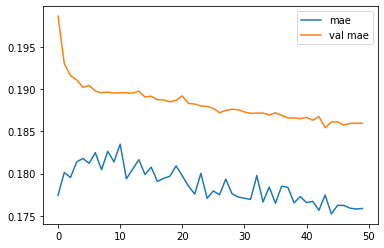

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabairawitmerah2_2 = pd.DataFrame()
data_new_cabairawitmerah2_2['actual'] = x_test
data_new_cabairawitmerah2_2['prediction'] = data_result2_2
data_new_cabairawitmerah2_2.to_csv('cabairawitmerah_model3_sgd-type3.csv')

data_new_cabairawitmerah2_2

181/181 [==============================] - 1s 4ms/step
14489.019 24.885593 17573.076679967002


,actual,prediction
0,62950,42930.285156
1,60300,42937.289062
2,57700,42895.007812
3,57000,42922.875000
4,55250,42870.785156
...,...,...
229,53000,58395.316406
230,72400,58510.738281
231,57200,58643.703125
232,64350,58252.664062


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 35ms/step - loss: 0.0712 - mae: 0.1792 - mape: 59.5921 - val_loss: 0.1402 - val_mae: 0.3309 - val_mape: 83.2344
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0390 - mae: 0.1545 - mape: 95.7794 - val_loss: 0.1172 - val_mae: 0.2981 - val_mape: 84.7059
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0392 - mae: 0.1487 - mape: 86.8730 - val_loss: 0.1204 - val_mae: 0.3027 - val_mape: 84.4670
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0388 - mae: 0.1504 - mape: 90.2432 - val_loss: 0.1145 - val_mae: 0.2937 - val_mape: 85.0133
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0384 - mae: 0.1469 - mape: 86.0965 - val_loss: 0.1165 - val_mae: 0.2964 - val_mape: 84.8093
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0379 - mae: 0.1464 - mape: 85.3211 - val_loss: 0.1065 - val_mae: 0.2813 - val_mape: 86.133

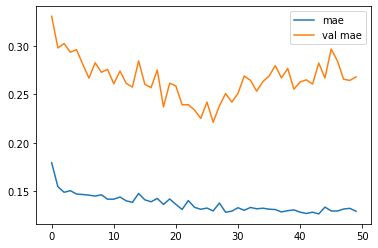

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_cabairawitmerah_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabairawitmerah2_a = pd.DataFrame()
data_new_cabairawitmerah2_a['actual'] = x_test
data_new_cabairawitmerah2_a['prediction'] = data_result2_a
data_new_cabairawitmerah2_a.to_csv('cabairawitmerah_model3_adam-type1.csv')

data_new_cabairawitmerah2_a

131/131 [==============================] - 1s 6ms/step
16610.752 27.420294 20021.228733521828


,actual,prediction
0,62950,39030.007812
1,60300,38375.765625
2,57700,38813.539062
3,57000,38998.363281
4,55250,39042.160156
...,...,...
229,53000,51790.648438
230,72400,53072.910156
231,57200,52201.937500
232,64350,53390.390625


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0414 - mae: 0.1602 - mape: 74.8242 - val_loss: 0.0846 - val_mae: 0.2455 - val_mape: 90.4695
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0384 - mae: 0.1546 - mape: 74.7269 - val_loss: 0.1062 - val_mae: 0.2832 - val_mape: 86.0378
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0381 - mae: 0.1551 - mape: 73.9763 - val_loss: 0.0915 - val_mae: 0.2619 - val_mape: 88.4616
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0381 - mae: 0.1529 - mape: 72.7699 - val_loss: 0.0666 - val_mae: 0.2091 - val_mape: 94.6108
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0370 - mae: 0.1509 - mape: 72.6036 - val_loss: 0.0797 - val_mae: 0.2430 - val_mape: 90.6404
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0389 - mae: 0.1566 - mape: 76.1786 - val_loss: 0.0704 - val_mae: 0.2225 - val_mape: 

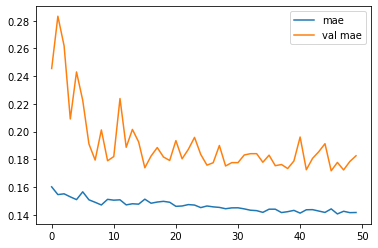

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
14324.395 24.244429 17392.218029912114


,actual,prediction
0,62950,42707.480469
1,60300,42940.460938
2,57700,42676.914062
3,57000,42573.824219
4,55250,42802.765625
...,...,...
229,53000,57891.042969
230,72400,60869.140625
231,57200,58142.019531
232,64350,62085.585938


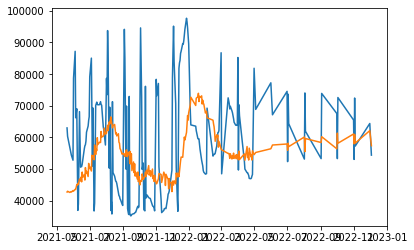

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_cabairawitmerah_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabairawitmerah2_a1 = pd.DataFrame()
data_new_cabairawitmerah2_a1['actual'] = x_test
data_new_cabairawitmerah2_a1['prediction'] = data_result2_a1
data_new_cabairawitmerah2_a1.to_csv('cabairawitmerah_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabairawitmerah2_a1.actual)
plt.plot(y_test, data_new_cabairawitmerah2_a1.prediction)
data_new_cabairawitmerah2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0383 - mae: 0.1467 - mape: 65.7331 - val_loss: 0.0680 - val_mae: 0.1838 - val_mape: 132.9557
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0375 - mae: 0.1418 - mape: 66.4064 - val_loss: 0.0674 - val_mae: 0.1831 - val_mape: 131.9648
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0374 - mae: 0.1457 - mape: 66.8410 - val_loss: 0.0773 - val_mae: 0.2007 - val_mape: 142.3849
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0373 - mae: 0.1427 - mape: 64.1478 - val_loss: 0.0714 - val_mae: 0.1900 - val_mape: 136.8546
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0380 - mae: 0.1456 - mape: 68.1115 - val_loss: 0.0663 - val_mae: 0.1821 - val_mape: 131.1497
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0368 - mae: 0.1423 - mape: 66.0789 - val_loss: 0.0681 - val_mae: 0.1831 - val_mape: 1

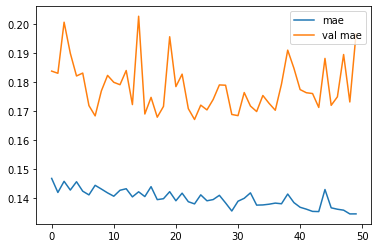

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
17629.021 34.380848 21792.530830539163


,actual,prediction
0,62950,45451.203125
1,60300,45735.589844
2,57700,45143.992188
3,57000,44367.476562
4,55250,44752.000000
...,...,...
229,53000,64553.402344
230,72400,63994.300781
231,57200,62955.996094
232,64350,62943.933594


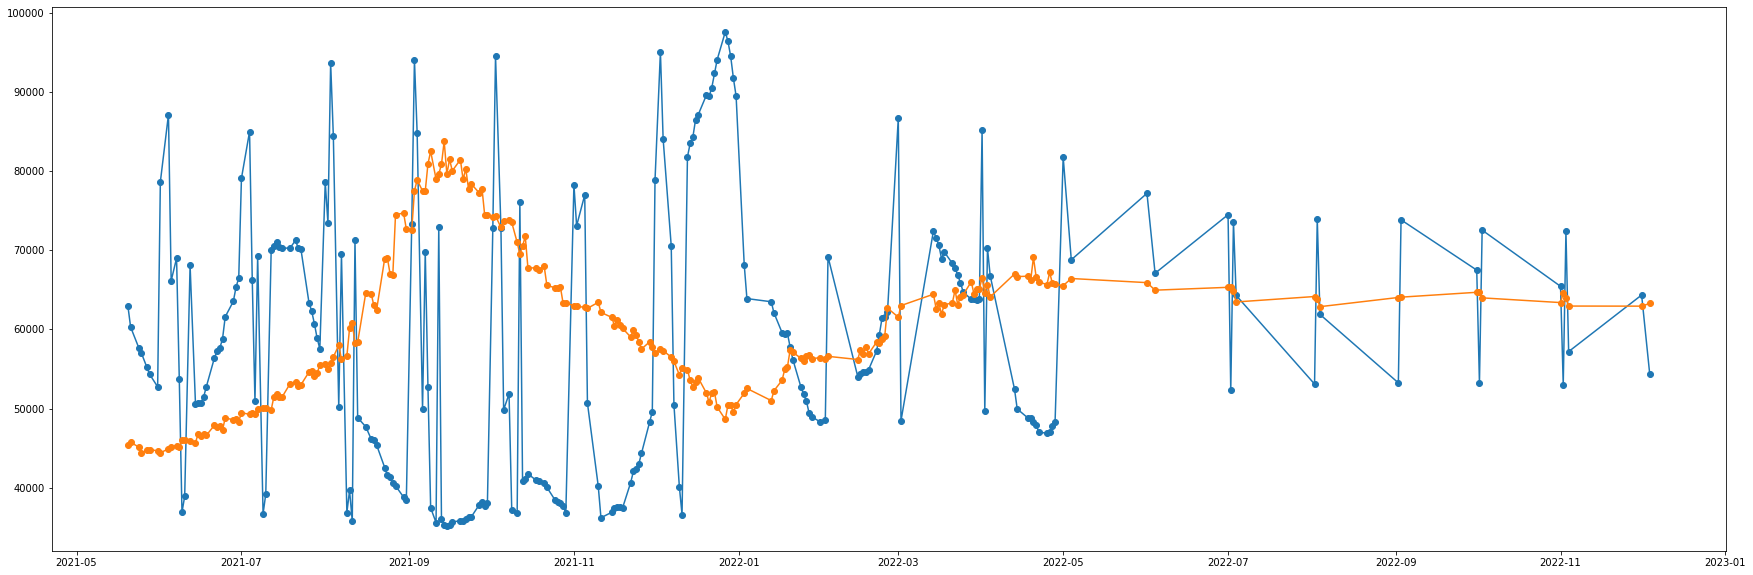

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_cabairawitmerah_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabairawitmerah2_a2 = pd.DataFrame()
data_new_cabairawitmerah2_a2['actual'] = x_test
data_new_cabairawitmerah2_a2['prediction'] = data_result2_a2
data_new_cabairawitmerah2_a2.to_csv('cabairawitmerah_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabairawitmerah2_a2.actual, '-o')
plt.plot(y_test,data_new_cabairawitmerah2_a2.prediction, '-o')
data_new_cabairawitmerah2_a2